In [45]:
import numpy as np
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import torch
from skorch import NeuralNetRegressor
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.insert(1, '../')
from data import load_narx_data, load_data
from model import Narx
from util_fun import calculate_error_nrms

In [46]:
na=5
nb=1
n_epochs=int(5e3)
n_hidden_nodes=50


In [47]:

x,y = load_narx_data(na, nb)
x_train, x_val, y_train, y_val =train_test_split(x, y, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_train, x_val, y_train, y_val=[x.to(device) for x in [x_train, x_val, y_train, y_val]]
best_RMS=float('inf')
best_model=None
losses=[]
RMSs=[]
best_RMSs=[]

model = Narx(x_train.shape[1], n_hidden_nodes).to(device) #a=)
optimizer = torch.optim.Adam(model.parameters()) #a)


In [52]:

for epoch in range(n_epochs): #a)
    Loss = torch.mean((model(x_train)-y_train)**2) #a)
    optimizer.zero_grad() #a)
    Loss.backward() #a)
    optimizer.step() #a)
    if (epoch+1)%min((n_epochs//20),1000)==0: #a) monitor
        print(f"current run: {na, nb}, epoch: {epoch+1}, Loss: {Loss.item()}") #a)
        RMS=np.mean((y_val.detach().cpu().numpy()-model.forward(x_val).detach().cpu().numpy())**2)**0.5
        if RMS < best_RMS:
            best_RMS=RMS
            best_model=deepcopy(model)
            print(f"current RMS: {RMS}, best RMS: {best_RMS}")
        losses.append(Loss.item())
        RMSs.append(RMS)
        best_RMSs.append(best_RMS)

current run: (5, 1), epoch: 250, Loss: 8.223574733930905e-05
current RMS: 0.011400803433667202, best RMS: 0.011400803433667202
current run: (5, 1), epoch: 500, Loss: 0.00011454482420452258
current run: (5, 1), epoch: 750, Loss: 7.93290709206385e-05
current RMS: 0.011190987242047111, best RMS: 0.011190987242047111
current run: (5, 1), epoch: 1000, Loss: 7.800521997263559e-05
current RMS: 0.011093727967995548, best RMS: 0.011093727967995548
current run: (5, 1), epoch: 1250, Loss: 0.0001158483683801738
current run: (5, 1), epoch: 1500, Loss: 7.559676450906063e-05
current RMS: 0.010913415953342939, best RMS: 0.010913415953342939
current run: (5, 1), epoch: 1750, Loss: 7.449328005057752e-05
current RMS: 0.010829291587224153, best RMS: 0.010829291587224153
current run: (5, 1), epoch: 2000, Loss: 7.343526302605004e-05
current RMS: 0.010748069878413787, best RMS: 0.010748069878413787
current run: (5, 1), epoch: 2250, Loss: 7.251456498691418e-05
current RMS: 0.0106767084979714, best RMS: 0.0106

In [53]:
x_data, y_data = load_data()
x_data, y_data=[x[:3000] for x in [x_data, y_data]]


#init upast and ypast as lists.
upast = [0]*nb 
ypast = [0]*na 

best_model=best_model.to(device)
ylist = []
for unow in x_data:
    #compute the current y given by f
    narx_input=torch.as_tensor(np.concatenate([upast,ypast])[None,:]).double()
    narx_input=narx_input.to(device)
    ynow = best_model.forward(narx_input).cpu().detach().item()
    
    #update past arrays
    upast.append(unow)
    upast.pop(0)
    ypast.append(ynow)
    ypast.pop(0)
    
    #save result
    ylist.append(ynow)


NRMS: 0.3996039724083302


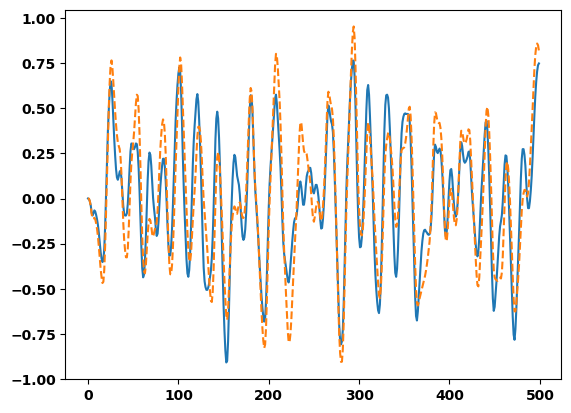

In [54]:
y_pred=np.array(ylist)
plt.plot(y_data[:500])
plt.plot(y_pred[:500], linestyle='--')
print(f'NRMS: {calculate_error_nrms(y_pred,y_data)}')